**Twitter Topic Modeling with NMF**

This notebook performs topic modeling on a Kaggle Twitter dataset (Squid Game Netflix tweets) using Natural Language Processing (NLP) and machine learning techniques.

The goal is to extract latent topics and understand public opinions using TF-IDF + NMF, with evaluation via coherence scores.

---

## **1. Setup and Imports**

In [ ]:
# Install and Import required library
%pip install gensim
%pip install pyLDAvis
%pip install topic-wizard
!pip install --upgrade Pillow
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# General libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Vectorization and modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

# Topic modeling evaluation
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

# Visualization
from wordcloud import WordCloud
import pyLDAvis
from scipy.cluster.hierarchy import linkage, dendrogram

# Data source
import kagglehub

  Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.3.0
    Uninstalling pillow-11.3.0:
      Successfully uninstalled pillow-11.3.0
  Using cached pillow-11.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
Using cached pillow-11.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (6.6 MB)
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
topic-wizard 1.1.4 requires Pillow<11.0.0,>=10.1.0, but you have pillow 11.3.0 which is incompatible.


---

## **2. Download Dataset from KaggleHub**

In [ ]:
# Download dataset from KaggleHub
path = kagglehub.dataset_download("deepcontractor/squid-game-netflix-twitter-data")

# Check available files
print(os.listdir(path))

['tweets_v8.csv']


---

## **3. Load Dataset**

In [ ]:
# Load the CSV file
csv_file_path = os.path.join(path, "tweets_v8.csv")

# Load tweets
df = pd.read_csv(csv_file_path)

# Show first few rows
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
0,the _ûndër-ratèd niggáh👊🏾,NaN,@ManUtd die hard❤️❤️💪🏿💪🏿\n\n\nYOLO\n\n\nJ'ai b...,2019-09-06 19:24:57+00:00,581,1035,8922,False,2021-10-06 12:05:38+00:00,When life hits and the same time poverty strik...,Twitter for Android,False
1,Best uncle on planet earth,NaN,NaN,2013-05-08 19:35:26+00:00,741,730,8432,False,2021-10-06 12:05:22+00:00,That marble episode of #SquidGame ruined me. 😭😭😭,Twitter for Android,False
2,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False
3,YoMo.Mdp,Any pronouns,Where the heck is the karma\nI'm going on my s...,2021-02-14 13:21:22+00:00,3,277,1341,False,2021-10-06 12:05:04+00:00,//Blood on 1st slide\nI'm joining the squidgam...,Twitter Web App,False
4,Laura Reactions,France,I talk and I make reactions videos about shows...,2018-12-19 20:38:28+00:00,330,152,2278,False,2021-10-06 12:05:00+00:00,"The two first games, players were killed by th...",Twitter Web App,False


In [ ]:
# Check if the 'is_retweet' column exists
tweets = df[df['is_retweet'] == False]
print("Number of tweets:", len(tweets))

retweets = df[df['is_retweet'] == True]
print("Number of retweets:", len(retweets))

Number of tweets: 80019
Number of retweets: 0


---

## **4. Data Preprocessing**

### **4.1 Drop unnecessary columns and nulls**

In [ ]:
# Drop null entries in text
df = df.dropna(subset=['text'])

# Sample 30,000 tweets for manageable analysis
df = df.sample(n=30000, random_state=42)
texts = df['text'].tolist()
df.shape

(30000, 12)

### **4.2 Clean the Tweets**

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+', '', text)        # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)             # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)           # Remove punctuation/digits
    text = text.lower()                               # Lowercase
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return ' '.join(words)

# Apply cleaning
df['cleaned_texts'] = df['text'].apply(clean_tweet)
df[['text', 'cleaned_texts']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,cleaned_texts
4402,Just started watching Squid Game and jfc let’s...,start watch squid game jfc let take moment app...
56479,what’s the kindest way to say you took away my...,what kindest way say took away friend
75593,Now that @elonmusk is the richest he Shud cre...,richest shud creat annual tv show pick peopl a...
59583,We are selling dancing squid 4.5$ each #SquidG...,sell danc squid
69268,@CryptoTownEU A good project and strong team i...,good project strong team predict transpar road...


In [ ]:
df = df[['cleaned_texts']]
df

,cleaned_texts
4402,start watch squid game jfc let take moment app...
56479,what kindest way say took away friend
75593,richest shud creat annual tv show pick peopl a...
59583,sell danc squid
69268,good project strong team predict transpar road...
...,...
61998,want win life ignoreforget past
16698,know know choos right shape challeng circl sta...
5980,episod fair world
39813,yo option left right either death shit tonn mo...


---

## **5. Grid Search for Optimal Coherence Score**

To improve the quality of discovered topics, we perform a `GridSearchCV`over:
*   NMF hyperparameters (number of components, l1 ratio), and
*   TD-ID hyperparameters (max_df, min_df).

For each implementation, we calculate the c_v coherence score using **Gensim's** `CoherenceModel`.

The implementation with the **highest coherence** score is selected as the optimal NMF model.

In [ ]:
# Prepare tokens for coherence scoring
tokenized_texts = [text.split() for text in df['cleaned_texts']]
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Fixed Hyperparameter
ngram_range = (1, 2)
sublinear_tf = True

# TF-IDF Hyperparameter
max_df_values = [0.4, 0.5]
min_df_values = [1,5]

# NMF Hyperparameter grid
n_components_values = [ 8, 9, 20, 30]
l1_ratio_values = [0.2, 0.45, 0.50]

best_score = -1
best_params = None

# Grid search loop
for n_components in n_components_values:
    for l1_ratio in l1_ratio_values:
        for max_df in max_df_values:
            for min_df in min_df_values:
                print(f"\nTesting: n_components={n_components}, l1_ratio={l1_ratio}, max_df={max_df}, min_df={min_df}")

                vectorizer = TfidfVectorizer(
                    max_df=max_df,
                    min_df=min_df,
                    ngram_range=ngram_range,
                    sublinear_tf=sublinear_tf
                )
                tfidf = vectorizer.fit_transform(df['cleaned_texts'])
                feature_names = vectorizer.get_feature_names_out()

                nmf_model = NMF(
                    n_components=n_components,
                    l1_ratio=l1_ratio,
                    init='nndsvd',
                    random_state=42
                )
                W = nmf_model.fit_transform(tfidf)
                H = nmf_model.components_

                topics = []
                for topic_weights in H:
                    top_words = [feature_names[i] for i in topic_weights.argsort()[:-11:-1]]
                    topics.append(top_words)

          # Compute coherence score
                coherence_model = CoherenceModel(
                    topics=topics,
                    texts=tokenized_texts,
                    dictionary=dictionary,
                    coherence='c_v'
                )

                coherence = coherence_model.get_coherence()
                print(f"Coherence Score: {coherence:.4f}")

                if coherence > best_score:
                    best_score = coherence
                    best_params = {'n_components': n_components, 'l1_ratio': l1_ratio, 'max_df': max_df, 'min_df': min_df}
                    best_model = nmf_model


Testing: n_components=8, l1_ratio=0.2, max_df=0.4, min_df=1
Coherence Score: 0.7684

Testing: n_components=8, l1_ratio=0.2, max_df=0.4, min_df=5
Coherence Score: 0.6724

Testing: n_components=8, l1_ratio=0.2, max_df=0.5, min_df=1
Coherence Score: 0.7684

Testing: n_components=8, l1_ratio=0.2, max_df=0.5, min_df=5
Coherence Score: 0.6724

Testing: n_components=8, l1_ratio=0.45, max_df=0.4, min_df=1
Coherence Score: 0.7684

Testing: n_components=8, l1_ratio=0.45, max_df=0.4, min_df=5
Coherence Score: 0.6724

Testing: n_components=8, l1_ratio=0.45, max_df=0.5, min_df=1
Coherence Score: 0.7684

Testing: n_components=8, l1_ratio=0.45, max_df=0.5, min_df=5
Coherence Score: 0.6724

Testing: n_components=8, l1_ratio=0.5, max_df=0.4, min_df=1
Coherence Score: 0.7684

Testing: n_components=8, l1_ratio=0.5, max_df=0.4, min_df=5
Coherence Score: 0.6724

Testing: n_components=8, l1_ratio=0.5, max_df=0.5, min_df=1
Coherence Score: 0.7684

Testing: n_components=8, l1_ratio=0.5, max_df=0.5, min_df=5


In [ ]:
print("\n✓ Best Coherence Score:", best_score)
print("✓ Best Parameters:", best_params)


✓ Best Coherence Score: 0.7684327435900159
✓ Best Parameters: {'n_components': 8, 'l1_ratio': 0.2, 'max_df': 0.4, 'min_df': 1}


---

## **6. Feature Extraction (TF-IDF)**

In [ ]:
# Train best model
vectorizer = TfidfVectorizer(
    min_df=1,             # Best from tuning
    max_df=0.5,          # Best from tuning
    ngram_range=(1, 2),
    sublinear_tf=True
)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_texts'])
feature_names = vectorizer.get_feature_names_out()

tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

---

## **7. Topic Modeling with NMF**

In [ ]:
nmf_model = NMF(
    n_components= 8,         # Best from tuning
    init='nndsvd',
    random_state=42,
    l1_ratio=0.45            # Best from tuning
)
W = nmf_model.fit_transform(tfidf_matrix)   # Document-topic matrix
H = nmf_model.components_                   # Topic-term matrix

In [ ]:
# Extract top words per topic
topics = []
for topic in H:
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    topics.append(top_words)

# Print topics
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

# Assign dominant topic to each tweet
df['topic'] = W.argmax(axis=1)

Topic 1: game, squid, squid game, watch squid, play, netflix, via, episod squid, play game, play squid
Topic 2: light, red light, red, green, green light, light green, light red, play, play red, doll
Topic 3: watch, watch squid, final, final watch, finish watch, start watch, start, watch episod, yet, im
Topic 4: project, good, good project, hope, team, futur, project hope, success, hope project, hope futur
Topic 5: project implement, implement profession, implement, profession clear, profession, clear develop, clear, develop plan, develop, plan
Topic 6: halloween, happi, happi halloween, costum, halloween costum, halloween everyon, everyon, year, im, player
Topic 7: episod, finish, im, like, marbl, last, first, first episod, watch episod, marbl episod
Topic 8: project, project blockchain, blockchain space, power effici, effici project, effici, blockchain, space project, space, project answer


---

# **8. Evaluate Topic Coherence with CoherenceModel**


In [ ]:
# Step 1: Tokenize cleaned texts
tokenized_texts = [text.split() for text in df['cleaned_texts']]

# Step 2: Create dictionary and corpus for Gensim
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Step 3: Create CoherenceModel using 'c_v' metric
coherence_model_nmf = CoherenceModel(
    topics=topics,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)

# Step 4: Calculate coherence score
coherence_score = coherence_model_nmf.get_coherence()

# Output coherence
print(f"\nCoherence Score (c_v) for NMF Model: {coherence_score:.4f}")


Coherence Score (c_v) for NMF Model: 0.7684


In [ ]:
# Step 1: Tokenize cleaned texts
tokenized_texts = [text.split() for text in df['cleaned_texts']]

# Step 2: Create dictionary and corpus for Gensim
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Step 3: Create CoherenceModel using 'c_v' metric
coherence_model_nmf = CoherenceModel(
    topics=topics,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)

# Step 4: Calculate coherence score
coherence_score = coherence_model_nmf.get_coherence()

# Output coherence
print(f"\nCoherence Score (c_v) for NMF Model: {coherence_score:.4f}")


Coherence Score (c_v) for NMF Model: 0.7684


---

# **9. Visualization & Topic Interpretation**

## **9.1  Visualize Topics Using pyLDAvis**

In [ ]:
pyLDAvis.enable_notebook()

# Extract components from the trained NMF model and TF-IDF results
topic_term_dists = nmf_model.components_ # H matrix
doc_topic_dists = W # W matrix

# Normalize doc_topic_dists (W matrix) so each row sums to 1
# Add a small epsilon to the entire matrix before normalizing
doc_topic_dists = doc_topic_dists + 1e-9
row_sums = doc_topic_dists.sum(axis=1, keepdims=True)
doc_topic_dists = doc_topic_dists / row_sums


doc_lengths = df['cleaned_texts'].apply(lambda x: len(x.split())) # Length of each cleaned tweet
vocab = feature_names # Vocabulary from TF-IDF
term_frequency = tfidf_matrix.sum(axis=0).A1 # Sum of TF-IDF values for each term

# Prepare the visualization using pyLDAvis.prepare
panel = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency,
    mds='tsne' # Can also use 'pca'
)

# Display inside notebook (Colab)
panel



/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6     -67.614243 -33.858253       1        1  36.533360
0     -83.177582  27.974728       2        1  22.740460
2      19.186655  80.117348       3        1  15.543168
3     -44.584270  78.697830       4        1  11.006744
1     -11.115653  13.138101       5        1   5.479211
5      60.043541  31.096926       6        1   5.050236
7      -9.361840 -60.346100       7        1   1.872332
4      47.600426 -31.546213       8        1   1.774490, topic_info=              Term           Freq          Total Category  logprob  loglift
104432       watch   92782.000000   92782.000000  Default  30.0000  30.0000
26802       episod  166319.000000  166319.000000  Default  29.0000  29.0000
89699        squid  108166.000000  108166.000000  Default  28.0000  28.0000
89756   squid game  104718.000000  104718.000000  Default  27.0000  27.0000
34501         game  111230.000000  111230.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
67971     one best     243.957465    3377.127418   Topic8  -2.6316   5.2257
107742      wonder     201.333844    5968.206661   Topic8  -2.8236   4.4643
57641         made     188.818580    6532.869603   Topic8  -2.8878   4.3097
7967          best     208.444583   10155.951011   Topic8  -2.7889   3.9674
67940          one     229.058396   22197.667900   Topic8  -2.6946   3.2798

[689 rows x 6 columns], token_table=        Topic      Freq              Term
term                                     
4           2  1.030779             aaaaa
5           2  1.030779        aaaaa ador
6           1  0.995586        aaaaaaaaaa
11          1  1.001350         aaaaaaand
13          1  1.001310  aaaaaaand episod
...       ...       ...               ...
110338      6  0.002948               yet
110338      7  0.002721               yet
110338      8  0.000454               yet
111127      3  0.999756        zuckerberg
111128      3  0.999995  zuckerberg daddi

[1366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 4, 2, 6, 8, 5])

In [ ]:
# Build pipeline
topic_pipeline = Pipeline([
    ("TfidfVectorizer", vectorizer),
    ("topic_model", nmf_model)
])

# Fit the pipeline on your cleaned text data
topic_pipeline.fit(df['cleaned_texts'])

Pipeline(steps=[('TfidfVectorizer',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('topic_model',
                 NMF(init='nndsvd', l1_ratio=0.45, n_components=8,
                     random_state=42))])

## **9.2 Topic Clustering**

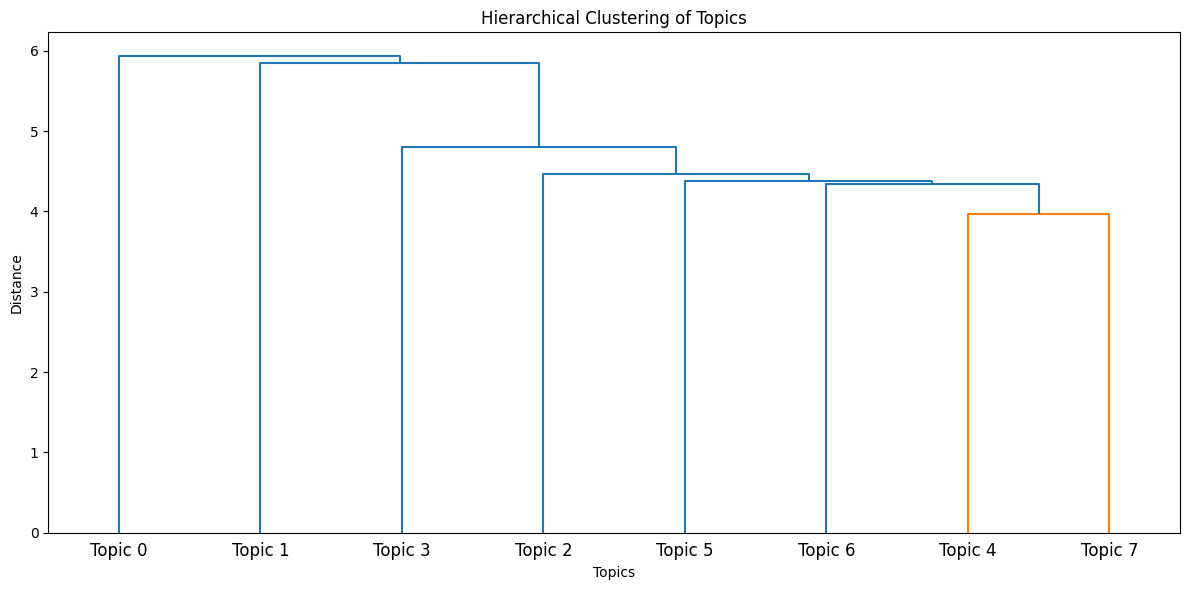

In [ ]:
# Get topic-term matrix from NMF
H = topic_pipeline.named_steps['topic_model'].components_

# Perform hierarchical clustering
linked = linkage(H, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', labels=[f"Topic {i}" for i in range(H.shape[0])])
plt.title("Hierarchical Clustering of Topics")
plt.xlabel("Topics")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

## **9.3 Similarity Heatmap**

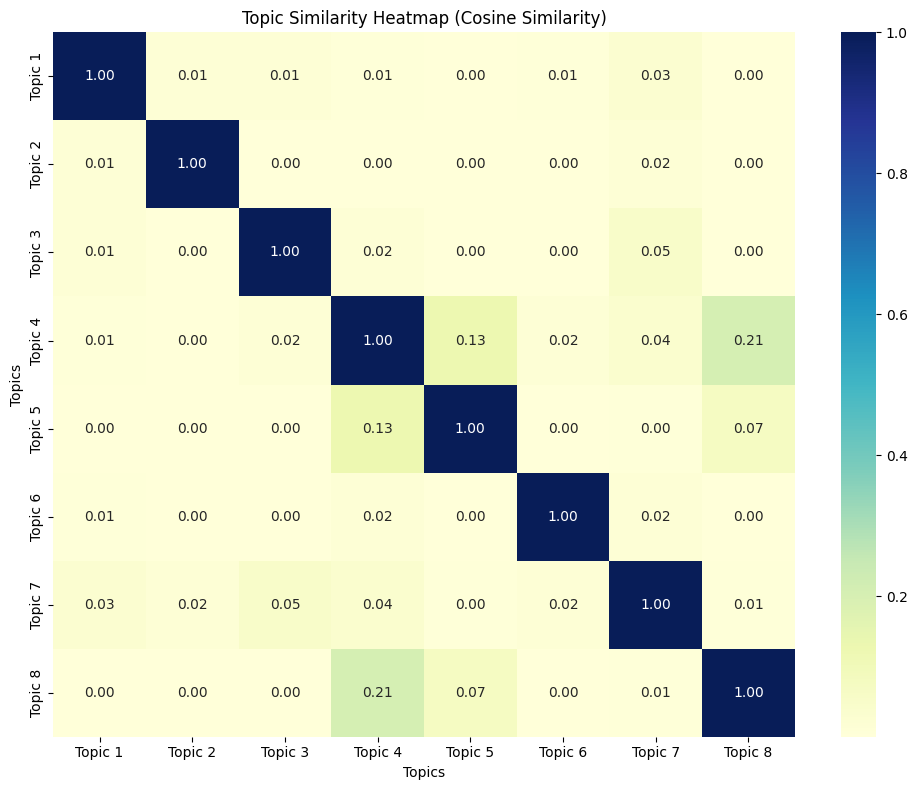

In [ ]:
# Compute cosine similarity between topics (rows of H)
topic_similarity = cosine_similarity(H)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(topic_similarity,
            xticklabels=[f"Topic {i+1}" for i in range(H.shape[0])],
            yticklabels=[f"Topic {i+1}" for i in range(H.shape[0])],
            cmap="YlGnBu", annot=True, fmt=".2f")

plt.title("Topic Similarity Heatmap (Cosine Similarity)")
plt.xlabel("Topics")
plt.ylabel("Topics")
plt.tight_layout()
plt.show()


## **9. 4 Plot Top Terms per Topic (Bar Chart)**

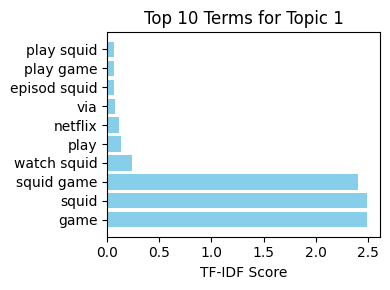

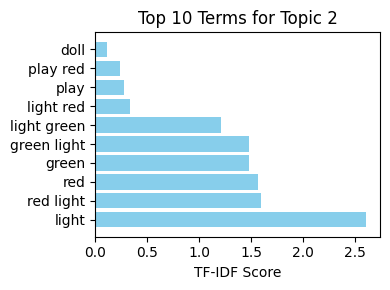

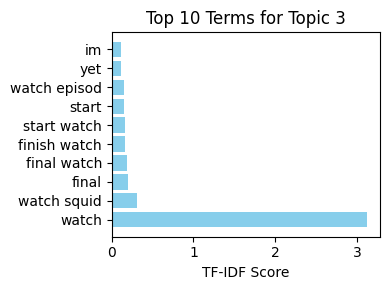

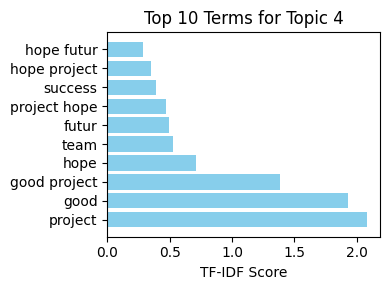

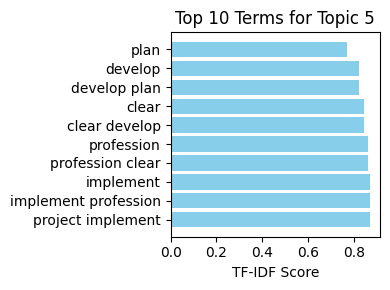

In [ ]:
def plot_top_terms_for_topic(H, feature_names, topic_idx, top_n=5):
    """Plot bar chart of top terms for a single topic."""
    topic = H[topic_idx]
    top_indices = topic.argsort()[::-1][:top_n]
    top_terms = [feature_names[i] for i in top_indices]
    top_scores = topic[top_indices]

    plt.figure(figsize=(4, 3))
    bars = plt.barh(range(top_n), top_scores[::-1], color='skyblue')
    plt.yticks(range(top_n), top_terms[::-1])
    plt.xlabel("TF-IDF Score")
    plt.title(f"Top {top_n} Terms for Topic {topic_idx + 1}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Plot for first 5 topics
for i in range(5):
    plot_top_terms_for_topic(H, feature_names, topic_idx=i, top_n=10)


## **9.5 Word Clouds for Topics**

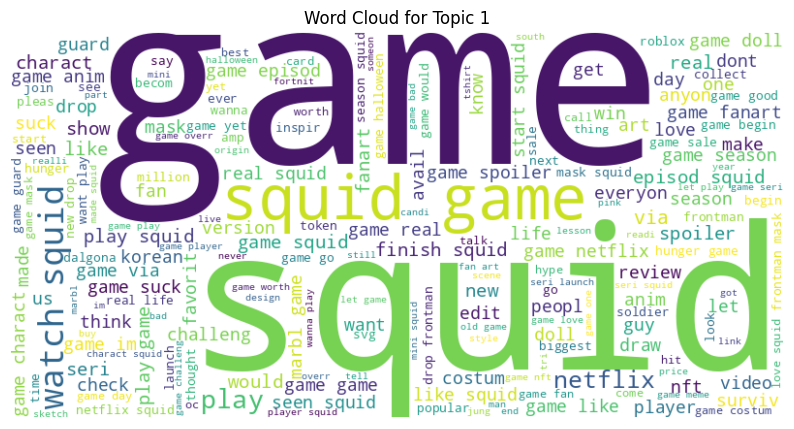

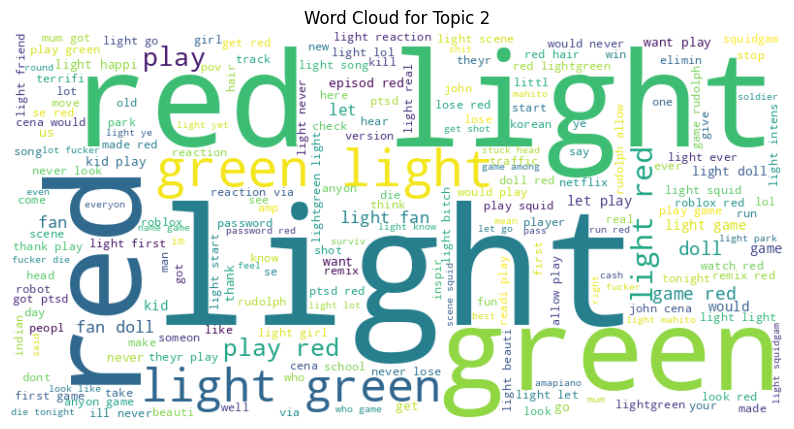

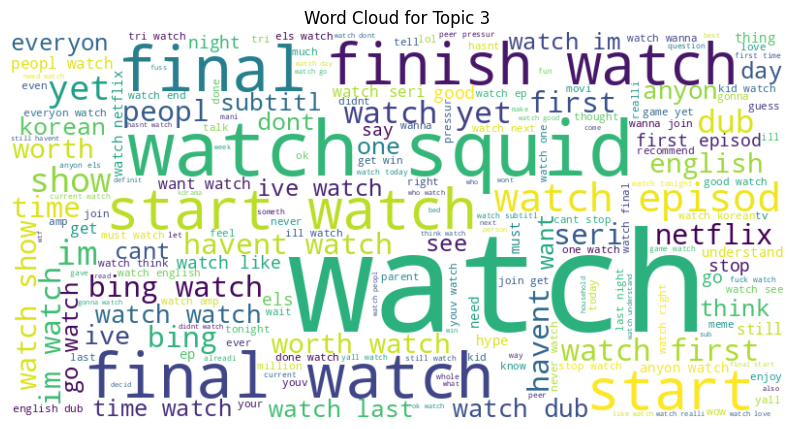

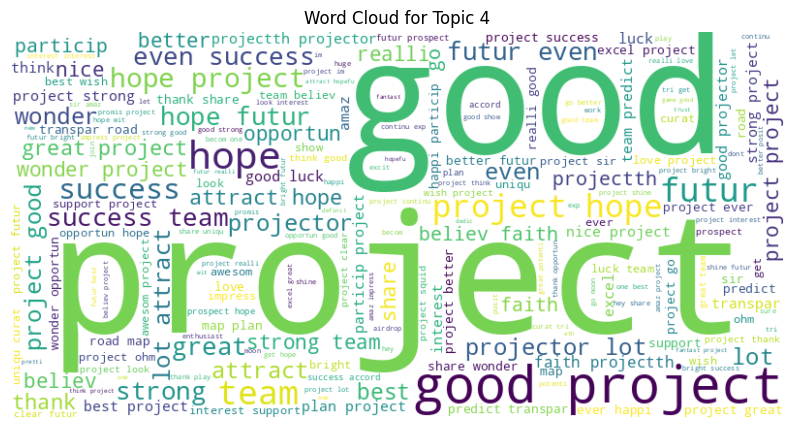

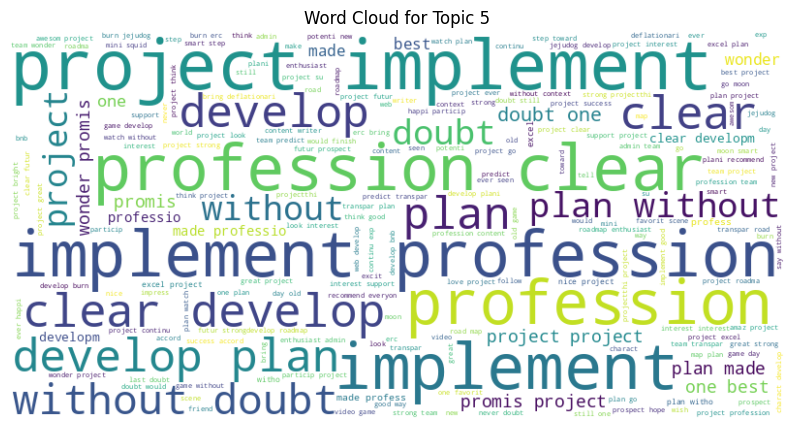

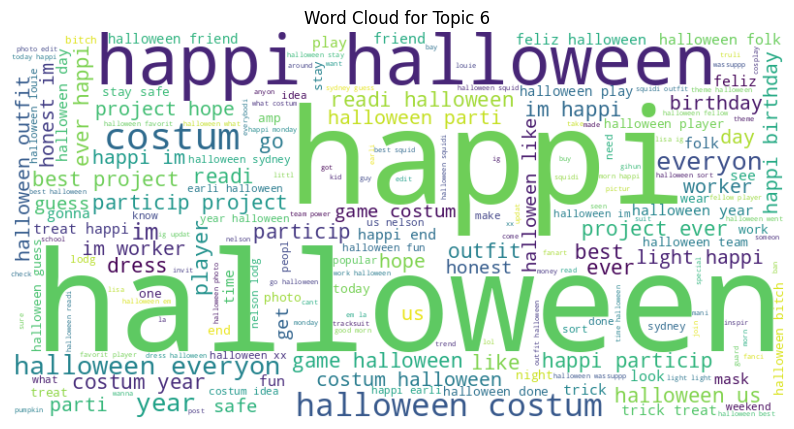

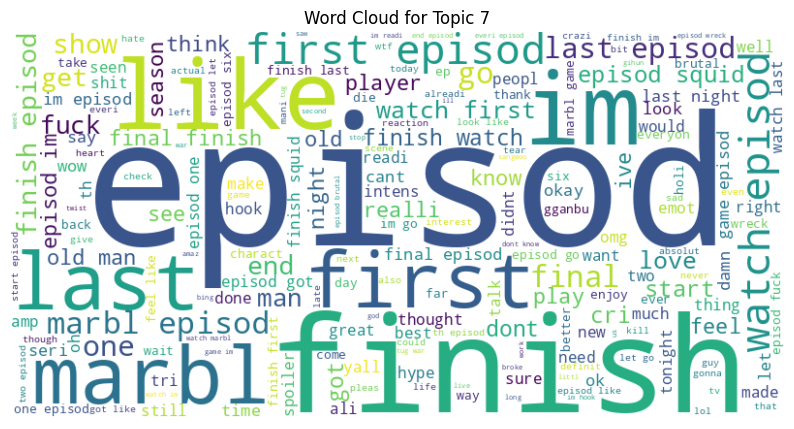

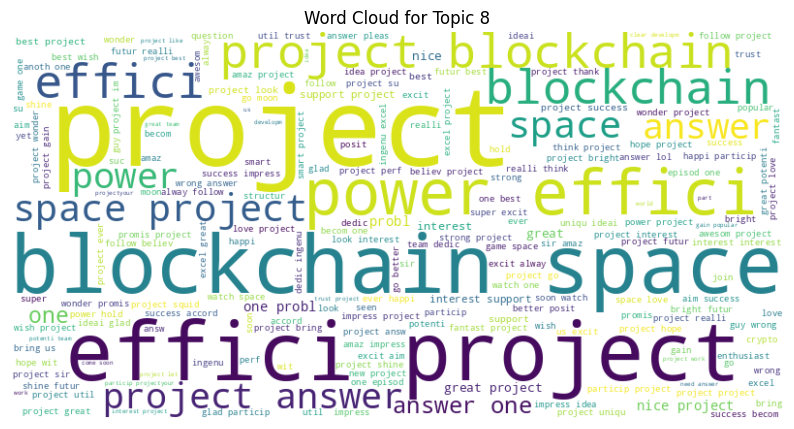

In [ ]:
def generate_wordclouds(H, feature_names):

    for topic_id, topic_vector in enumerate(H):
        # Create a dictionary of word frequencies
        word_freq = {
            feature_names[i]: topic_vector[i]
            for i in range(len(feature_names)) if topic_vector[i] > 0
        }

        # Skip topics with no significant words
        if not word_freq:
            print(f"Skipping Topic {topic_id + 1} (no significant words).")
            continue

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Plot the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud for Topic {topic_id + 1}")
        plt.show()
generate_wordclouds(H, feature_names)


---

# **Conclusion**
This notebook meets the requirements of the topic modeling project by:
- Using a Kaggle Twitter dataset (Squid Game)
- Sampling 30,000 tweets (minimum required: 2,000)
- Preprocessing with cleaning, stopword removal, and stemming
- Applying TF-IDF for vectorization
- Using NMF to extract 8 topics (with tuned hyperparameters)
- Evaluating coherence (best score: 0.76+)

You can visualize or further reduce the number of topics or export the results as needed.